# Gender bias analysis in the adult dataset

This notebook contains the example included in the paper "Explainable artificial intelligence for the detection and analysis of gender bias in machine learning models". The paper was presented at the 1st Scientific Meeting on Research with a Gender Perspective, organised by the University of Córdoba on 14th February 2023.

Author: Aurora Ramirez (University of Córdoba, Spain)

Date: February 2023

### Dependencies

This notebook has been coded with Python 3.10.2. You can install the dependencies using the requirements.txt file in this folder.

### Dataset

This notebook uses the **Adult** dataset which can be downloaded from the UCI repository: https://archive.ics.uci.edu/ml/datasets/adult

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
import dice_ml

In [2]:
# Open dataset
file = 'adult.csv'
df = pd.read_csv(file)
display(df.head())
display(df.shape)

high_income = len(df[df['income']==1])
low_income = len(df[df['income']==0])
print(high_income*100/df.shape[0])
print(low_income*100/df.shape[0])

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,Non-Private,77516,13,Non-Married,Managerial-Specialist,Non-Husband,White,Male,2174,0,40,US,0
1,50,Non-Private,83311,13,Married,Managerial-Specialist,Husband,White,Male,0,0,13,US,0
2,38,Private,215646,9,Non-Married,Other,Non-Husband,White,Male,0,0,40,US,0
3,53,Private,234721,7,Married,Other,Husband,Non-White,Male,0,0,40,US,0
4,28,Private,338409,13,Married,Managerial-Specialist,Non-Husband,Non-White,Female,0,0,40,Non-US,0


(48832, 14)

23.933076671035387
76.06692332896462


In [3]:
# Preprocessing
df['sex']=df['sex'].replace('Female', 0)
df['sex']=df['sex'].replace('Male', 1)

categorical=["workclass","marital-status","occupation","relationship","race","native-country"]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
transformations = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', RandomForestClassifier())])

In [5]:
# Basic statistics by gender
df_women = df[df['sex']==0]
df_men = df[df['sex']==1]

num_women = len(df_women)
num_men = len(df_men)

num_women_high_income = len(df_women[df_women['income']==1])
num_women_low_income = len(df_women[df_women['income']==0])
num_men_high_income = len(df_men[df_men['income']==1])
num_men_low_income = len(df_men[df_men['income']==0])

print(f"Num women: {num_women} -> High income: {num_women_high_income}, Low income: {num_women_low_income}")
print(f"Num men: {num_men} -> High income: {num_men_high_income}, Low income: {num_men_low_income}")

Num women: 16189 -> High income: 1769, Low income: 14420
Num men: 32643 -> High income: 9918, Low income: 22725


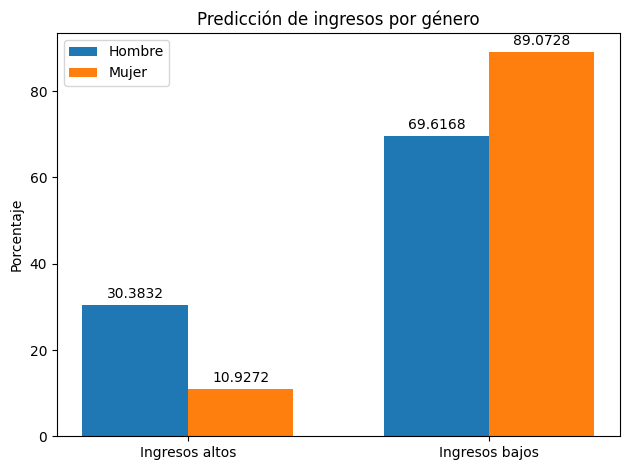

In [7]:
# Graphic
labels = ["Ingresos altos", "Ingresos bajos"]
men_values = [num_men_high_income*100/num_men, num_men_low_income*100/num_men]
women_values = [num_women_high_income*100/num_women, num_women_low_income*100/num_women]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_values, width, label='Hombre')
rects2 = ax.bar(x + width/2, women_values, width, label='Mujer')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Porcentaje')
ax.set_title('Predicción de ingresos por género')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

In [8]:
# Split train and test
target = df["income"]
feature_names = df.drop('income', axis=1).columns
train_dataset, test_dataset, y_train, y_test = train_test_split(df,
                                                                target,
                                                                test_size=0.33,
                                                                random_state=0,
                                                                stratify=target)
x_train = train_dataset.drop('income', axis=1)
x_test = test_dataset.drop('income', axis=1)

In [9]:
# Full model
model = clf.fit(x_train, y_train)
y_pred = model.predict(x_test)
precis = round(accuracy_score(y_test, y_pred)*100,2)
print(f"The accuracy of the model is {precis} %")
print(confusion_matrix(y_test, y_pred))

The accuracy of the model is 79.3 %
[[11136  1122]
 [ 2214  1643]]


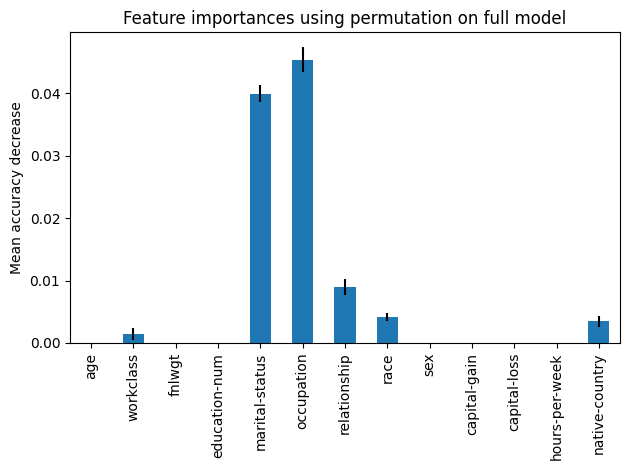

In [10]:
# Feature importance
result = permutation_importance(
    model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [11]:
# Men model
target = df_men["income"]
feature_names = df_men.drop('income', axis=1).columns
train_dataset, test_dataset, y_train, y_test = train_test_split(df_men,
                                                                target,
                                                                test_size=0.33,
                                                                random_state=0,
                                                                stratify=target)
x_train = train_dataset.drop('income', axis=1)
x_test = test_dataset.drop('income', axis=1)

In [12]:
model = clf.fit(x_train, y_train)
y_pred = model.predict(x_test)
precis = round(accuracy_score(y_test, y_pred)*100,2)
print(f"The accuracy of the model (men) is {precis} %")
print(confusion_matrix(y_test, y_pred))

The accuracy of the model (men) is 74.13 %
[[6421 1079]
 [1708 1565]]


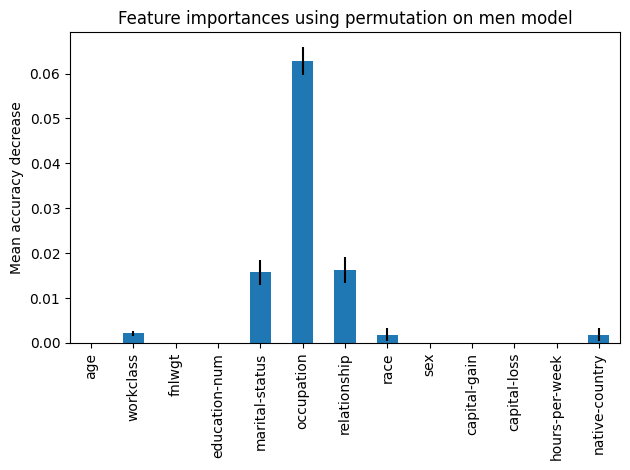

In [13]:
# Feature importance
result = permutation_importance(
    model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on men model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [14]:
# Counterfactuals
continuous = ["age","fnlwgt","education-num","capital-gain","capital-loss"]

d = dice_ml.Data(dataframe=train_dataset, continuous_features=continuous, outcome_name='income')
m = dice_ml.Model(model=model, backend="sklearn")
exp = dice_ml.Dice(d, m, method="random")
factuals = test_dataset[test_dataset['income']==0]
factuals.drop(['income'], axis=1, inplace=True)
factuals = factuals.iloc[:5,:]

results = exp.generate_counterfactuals(factuals,
                                posthoc_sparsity_param=0.1,
                                total_CFs=5,
                                desired_class=1,
                                permitted_range={'age': [20, 80]},
)

results.visualize_as_dataframe(show_only_changes=True)

C:\Users\auror\AppData\Local\Temp\ipykernel_14676\2096291345.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factuals.drop(['income'], axis=1, inplace=True)
100%|██████████| 5/5 [00:00<00:00,  5.21it/s]

Query instance (original outcome : 0)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,29,Private,307812,9,Married,Other,Husband,White,1,0,0,60,US,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,-,-,-,-,Managerial-Specialist,-,-,1,-,-,60,-,1
1,-,-,1457443.0,-,-,Managerial-Specialist,-,-,1,-,-,60,-,1
2,73.0,-,-,-,-,Managerial-Specialist,-,-,1,-,-,60,-,1
3,35.0,-,-,-,-,Managerial-Specialist,-,-,1,-,-,60,-,1
4,-,Non-Private,-,-,-,Managerial-Specialist,-,-,1,-,-,60,-,1


Query instance (original outcome : 0)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,63,Non-Private,99823,10,Married,Other,Husband,White,1,0,0,32,US,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,-,-,-,-,Managerial-Specialist,-,-,1,-,-,32,Non-US,1
1,-,-,-,-,-,Managerial-Specialist,-,Non-White,1,-,-,32,-,1
2,-,-,-,-,-,Managerial-Specialist,-,-,-,-,-,32,-,1
3,-,-,-,-,-,Managerial-Specialist,-,-,1,-,-,40,-,1
4,-,-,-,-,-,Managerial-Specialist,-,-,1,84840.0,-,32,-,1


Query instance (original outcome : 0)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,20,Private,34568,9,Married,Other,Husband,White,1,3781,0,35,US,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,-,-,-,-,Managerial-Specialist,-,-,1,-,3546.0,35,-,1
1,-,-,-,12.0,-,Managerial-Specialist,-,-,1,-,-,35,-,1
2,-,-,-,2.0,-,Managerial-Specialist,-,-,1,-,-,35,-,1
3,-,-,1328870.0,-,-,Managerial-Specialist,-,-,1,-,-,35,-,1
4,-,-,-,-,-,Managerial-Specialist,-,-,1,-,2559.0,35,-,1


Query instance (original outcome : 0)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,27,Private,137063,13,Married,Other,Husband,White,1,0,0,50,US,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,-,-,-,-,Managerial-Specialist,-,-,1,-,314.0,50,-,1
1,-,-,-,-,-,Managerial-Specialist,-,-,1,-,-,40,-,1
2,-,-,-,-,-,Managerial-Specialist,-,-,1,-,2034.0,50,-,1
3,75.0,-,-,-,-,Managerial-Specialist,-,-,1,-,-,50,-,1
4,-,-,-,3.0,-,Managerial-Specialist,-,-,1,-,-,50,-,1


Query instance (original outcome : 0)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,43,Private,557349,6,Married,Other,Husband,White,1,0,0,40,Non-US,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,Non-Private,-,-,-,Managerial-Specialist,-,-,1,-,2317.0,40,-,1
1,-,Non-Private,-,-,-,Managerial-Specialist,-,-,1,-,3290.0,40,-,1
2,72.0,Non-Private,-,-,-,Managerial-Specialist,-,-,1,-,-,40,-,1
3,-,Non-Private,-,-,-,Managerial-Specialist,-,-,1,88191.0,-,40,-,1
4,-,-,-,-,-,Managerial-Specialist,-,-,1,-,-,40,US,1


In [15]:
# Women model
target = df_women["income"]
feature_names = df_women.drop('income', axis=1).columns
train_dataset, test_dataset, y_train, y_test = train_test_split(df_women,
                                                                target,
                                                                test_size=0.33,
                                                                random_state=0,
                                                                stratify=target)
x_train = train_dataset.drop('income', axis=1)
x_test = test_dataset.drop('income', axis=1)

In [16]:
model = clf.fit(x_train, y_train)
y_pred = model.predict(x_test)
precis = round(accuracy_score(y_test, y_pred)*100,2)
print(f"The accuracy of the model (women) is {precis} %")
print(confusion_matrix(y_test, y_pred))

The accuracy of the model (women) is 90.62 %
[[4567  192]
 [ 309  275]]


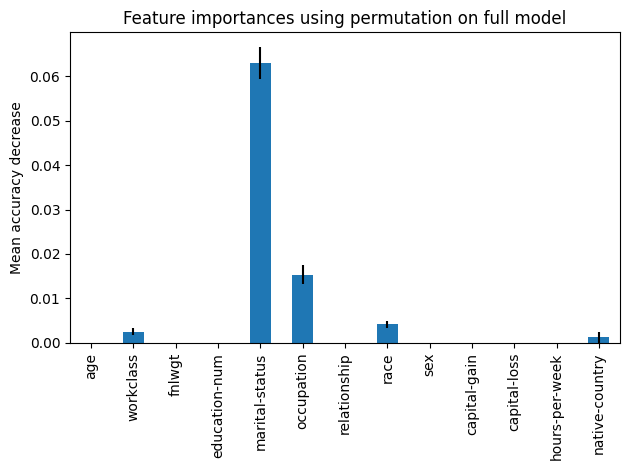

In [17]:
# Feature importance
result = permutation_importance(
    model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [18]:
continuous = ["age","fnlwgt","education-num","capital-gain","capital-loss"]

d = dice_ml.Data(dataframe=train_dataset, continuous_features=continuous, outcome_name='income')
m = dice_ml.Model(model=model, backend="sklearn")
exp = dice_ml.Dice(d, m, method="random")
factuals = test_dataset[test_dataset['income']==0]
factuals.drop(['income'], axis=1, inplace=True)
factuals = factuals.iloc[:10,:]

results = exp.generate_counterfactuals(factuals,
                                posthoc_sparsity_param=0.1,
                                total_CFs=5,
                                desired_class=1,
                                permitted_range={'age': [20, 80]},
)

results.visualize_as_dataframe(show_only_changes=True)

C:\Users\auror\AppData\Local\Temp\ipykernel_14676\423237272.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factuals.drop(['income'], axis=1, inplace=True)
100%|██████████| 10/10 [00:01<00:00,  5.38it/s]

Query instance (original outcome : 0)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,18,Private,430930,7,Non-Married,Other,Non-Husband,White,0,0,0,6,US,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,-,-,-,Married,Managerial-Specialist,-,-,0,-,-,6,-,1
1,-,Non-Private,-,-,Married,Managerial-Specialist,-,-,0,-,-,6,-,1
2,-,-,-,-,Married,Managerial-Specialist,-,-,0,42223.0,-,6,-,1
3,-,-,-,-,Married,Managerial-Specialist,-,-,0,23346.0,-,6,-,1
4,-,-,-,-,Married,Managerial-Specialist,-,-,0,-,-,6,-,1


Query instance (original outcome : 0)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,20,Private,214238,7,Non-Married,Other,Non-Husband,White,0,0,0,32,Non-US,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,Non-Private,-,-,Married,Managerial-Specialist,-,-,0,4860.0,-,79,-,1
1,-,Non-Private,-,-,Married,Managerial-Specialist,-,-,-,-,-,32,-,1
2,40.0,Non-Private,-,-,Married,-,-,Non-White,0,-,3660.0,32,-,1
3,-,Non-Private,-,-,Married,-,-,Non-White,0,-,-,32,-,1
4,-,Non-Private,-,-,Married,Managerial-Specialist,-,-,0,83749.0,-,32,-,1


Query instance (original outcome : 1)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,19,Private,205977,10,Married,Managerial-Specialist,Non-Husband,White,0,0,0,20,US,1



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,-,-,-,-,-,-,-,0,-,2108.0,20,-,-
1,24.0,-,-,-,-,-,-,-,0,-,-,20,-,-
2,29.0,-,-,-,-,-,-,-,0,-,1046.0,20,-,-
3,-,-,-,-,-,-,-,-,0,27543.0,-,20,-,-
4,-,-,-,15.0,-,-,-,-,-,-,-,20,-,-


Query instance (original outcome : 0)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,42,Non-Private,557644,9,Non-Married,Managerial-Specialist,Non-Husband,White,0,0,0,40,US,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,-,771045.0,-,Married,-,-,-,0,-,-,40,-,1
1,-,-,-,-,Married,-,-,-,0,-,-,80,-,1
2,-,-,-,-,Married,-,-,-,0,-,1809.0,40,-,1
3,-,-,-,-,Married,-,-,-,0,-,-,21,-,1
4,-,-,-,-,Married,-,-,-,0,-,-,58,-,1


Query instance (original outcome : 0)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,17,Private,114798,6,Non-Married,Other,Non-Husband,White,0,0,0,20,US,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,-,-,-,Married,Managerial-Specialist,-,-,0,-,-,20,-,1
1,-,-,758070.0,-,Married,Managerial-Specialist,-,-,0,-,-,20,-,1
2,-,-,-,-,Married,Managerial-Specialist,-,-,-,-,-,20,-,1
3,-,-,-,-,Married,Managerial-Specialist,-,-,0,-,-,20,-,1
4,-,-,-,-,Married,Managerial-Specialist,-,-,0,77712.0,-,20,-,1


Query instance (original outcome : 0)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,18,Private,31008,10,Non-Married,Other,Non-Husband,White,0,0,0,40,US,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,-,-,-,Married,Managerial-Specialist,-,-,-,-,-,40,-,1
1,-,-,-,-,Married,Managerial-Specialist,-,-,0,-,2548.0,40,-,1
2,57.0,-,-,-,Married,Managerial-Specialist,-,-,0,-,-,40,-,1
3,-,-,-,-,Married,Managerial-Specialist,-,-,0,-,-,40,-,1
4,-,-,-,-,Married,Managerial-Specialist,-,-,0,-,440.0,40,-,1


Query instance (original outcome : 0)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,93223,10,Non-Married,Managerial-Specialist,Non-Husband,White,0,0,0,35,US,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,-,-,-,Married,-,-,-,-,-,-,35,-,1
1,-,-,-,-,Married,-,-,-,0,-,3234.0,35,-,1
2,-,-,-,3.0,Married,-,-,-,0,-,-,35,-,1
3,-,-,-,-,Married,-,-,-,0,25484.0,-,35,-,1
4,-,-,-,-,Married,-,-,-,0,-,3275.0,35,-,1


Query instance (original outcome : 0)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,45,Non-Private,27184,9,Non-Married,Managerial-Specialist,Non-Husband,White,0,0,0,38,US,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,-,-,5.0,Married,-,-,-,0,-,-,38,-,1
1,-,-,982385.0,-,Married,-,-,-,0,-,-,38,-,1
2,57.0,-,-,-,Married,-,-,-,0,-,-,38,-,1
3,-,Private,-,-,Married,-,-,-,0,-,-,38,-,1
4,49.0,-,-,-,Married,-,-,-,0,-,-,38,-,1


Query instance (original outcome : 0)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,40,Private,146653,13,Non-Married,Managerial-Specialist,Non-Husband,White,0,0,0,20,US,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,-,-,-,Married,-,-,-,0,-,2882.0,20,-,1
1,-,-,-,-,Married,-,-,-,-,-,-,20,-,1
2,-,-,-,-,Married,-,-,-,0,-,-,48,-,1
3,-,-,-,-,Married,-,-,-,0,-,2621.0,20,-,1
4,-,-,27573.0,-,Married,-,-,-,0,-,-,20,-,1


Query instance (original outcome : 0)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,42,Private,32080,9,Non-Married,Managerial-Specialist,Non-Husband,White,0,0,0,40,US,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,Non-Private,-,-,Married,-,-,-,0,-,-,40,-,1
1,-,-,-,-,Married,-,-,-,0,8367.0,-,40,-,1
2,-,-,287630.0,-,Married,-,-,-,0,-,-,40,-,1
3,75.0,-,-,-,Married,-,-,-,0,-,-,40,-,1
4,-,-,182268.0,-,Married,-,-,-,0,-,-,40,-,1
